# Definitions

In [131]:
import dbm
import math
import random
from datetime import datetime
from typing import Dict

import ujson
import yaml
from pathlib import Path

import numpy as np
import pandas as pd
import requests as r
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
data_path = Path('..', 'data')
data_path.exists()

True

In [8]:
# VW minimizes loss/cost, therefore we will pass cost as -reward
USER_LIKED_TEMPERATURE = -1.0
USER_DISLIKED_TEMPERATURE = 0.0

## Simulate reward

In the real world we will have to learn the room temperature preferences as we observe the interactions between the proposed temperature for each room and the one selected by the people living in the house. Since this is a simulation we will have to define the preference profile for each room. The reward that we provide to the learner will follow this preference profile. Our hope is to see if the learner can take better and better decisions as we see more samples which in turn means we are maximizing the reward.

We will also modify the reward function in a few different ways and see if the CB learner picks up the changes. We will compare the TR with and without learning.

VW minimizes the cost, which is defined as -reward. Therefore, we will pass the cost associated to each chosen action to VW.


The reward function below specifies that we want the living room to be cold in the morning but warm in the afternoon. In reverse, we prefer the bedroom to be warm in the morning and cold in the afternoon. It looks dense but we are just simulating our hypothetical world in the format of the feedback the learner understands: cost. If the learner recommends a temperature that aligns with the reward function, we give a positive reward. Max reward is -1.0, min reward is 0 since VW learns in terms of cost, so we return a negative reward. In our simulated world this is the difference between the temperature recommended and the temperature chosen. If the difference is smaller than 5 degrees then we give a reward to the thermostat. This is a steep cost function.

In [35]:
def get_cost(context, temperature):
    if context["room"] == "Living Room":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        elif context["time_of_day"] == "afternoon":
            selected_temperature = random.uniform(25, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        else:
            return USER_DISLIKED_TEMPERATURE
    elif context["room"] == "Bedroom":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(22, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        elif context["time_of_day"] == "afternoon":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        else:
            return USER_DISLIKED_TEMPERATURE
    else:
        return USER_DISLIKED_TEMPERATURE

# Test requesting

In [13]:
def make_context(room: str, time_of_day: str) -> Dict[str, str]:
    return {"room": room, "time_of_day": time_of_day}

In [23]:
def make_label(action: float, cost: float, pdf_value: float) -> Dict[str, float]:
    return {"action": action, "cost": cost, "pdf_value": pdf_value}

In [14]:
host = 'http://192.168.1.3:1337'

In [17]:
r.get(host+'/time').text

'2022-06-12 16:04:39.154890'

In [22]:
r.post(host+'/predict', json=make_context('Living Room', 'morning')).json()

{'action': 3.2255001068115234, 'pdf_value': 0.22812499105930328}

In [27]:
r.post(
    host+'/update',
    json={
        'context': make_context('Living Room', 'morning'),
        'label': make_label(action=3.22, cost=0, pdf_value=0.228),
    },
).json()

{'status': 'OK'}

# Run coninuous simulation

In [154]:
rewards = []
pred_times = []
update_times = []
for _ in tqdm(range(10_000)):
    context = make_context(
        room=random.choice(["Living Room", "Bedroom"]),
        time_of_day=random.choice(["morning", "afternoon"]),
    )
    prediction_start = datetime.now()
    prediction = r.post(
        host+'/predict',
        json=context,
    ).json()
    pred_times.append(datetime.now() - prediction_start)

    cost = get_cost(context, prediction['action'])

    update_start = datetime.now()
    r.post(
        host+'/update',
        json={
            'context': context,
            'label': make_label(
                prediction['action'],
                cost,
                prediction['pdf_value'],
            ),
        }
    )
    update_times.append(datetime.now() - update_start)

    rewards.append(-cost)

  0%|          | 0/10000 [00:00<?, ?it/s]

JSONDecodeError: [Errno Expecting value] <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
  "http://www.w3.org/TR/html4/loose.dtd">
<html>
  <head>
    <title>KeyError: &#x27;context&#x27; // Werkzeug Debugger</title>
    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css"
        type="text/css">
    <!-- We need to make sure this has a favicon so that the debugger does
         not accidentally trigger a request to /favicon.ico which might
         change the application's state. -->
    <link rel="shortcut icon"
        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">
    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>
    <script type="text/javascript">
      var TRACEBACK = 140254444414624,
          CONSOLE_MODE = false,
          EVALEX = true,
          EVALEX_TRUSTED = false,
          SECRET = "QlsB2NZb7SFsKHLm3B1y";
    </script>
  </head>
  <body style="background-color: #fff">
    <div class="debugger">
<h1>KeyError</h1>
<div class="detail">
  <p class="errormsg">KeyError: &#x27;context&#x27;</p>
</div>
<h2 class="traceback">Traceback <em>(most recent call last)</em></h2>
<div class="traceback">
  <h3></h3>
  <ul><li><div class="frame" id="frame-140254444413280">
  <h4>File <cite class="filename">"/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2091</em>,
      in <code class="function">__call__</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">    </span>def __call__(self, environ: dict, start_response: t.Callable) -&gt; t.Any:</pre>
<pre class="line before"><span class="ws">        </span>&quot;&quot;&quot;The WSGI server calls the Flask application object as the</pre>
<pre class="line before"><span class="ws">        </span>WSGI application. This calls :meth:`wsgi_app`, which can be</pre>
<pre class="line before"><span class="ws">        </span>wrapped to apply middleware.</pre>
<pre class="line before"><span class="ws">        </span>&quot;&quot;&quot;</pre>
<pre class="line current"><span class="ws">        </span>return self.wsgi_app(environ, start_response)</pre></div>
</div>

<li><div class="frame" id="frame-140254444413328">
  <h4>File <cite class="filename">"/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2076</em>,
      in <code class="function">wsgi_app</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>try:</pre>
<pre class="line before"><span class="ws">                </span>ctx.push()</pre>
<pre class="line before"><span class="ws">                </span>response = self.full_dispatch_request()</pre>
<pre class="line before"><span class="ws">            </span>except Exception as e:</pre>
<pre class="line before"><span class="ws">                </span>error = e</pre>
<pre class="line current"><span class="ws">                </span>response = self.handle_exception(e)</pre>
<pre class="line after"><span class="ws">            </span>except:  # noqa: B001</pre>
<pre class="line after"><span class="ws">                </span>error = sys.exc_info()[1]</pre>
<pre class="line after"><span class="ws">                </span>raise</pre>
<pre class="line after"><span class="ws">            </span>return response(environ, start_response)</pre>
<pre class="line after"><span class="ws">        </span>finally:</pre></div>
</div>

<li><div class="frame" id="frame-140254444413424">
  <h4>File <cite class="filename">"/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2073</em>,
      in <code class="function">wsgi_app</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">        </span>ctx = self.request_context(environ)</pre>
<pre class="line before"><span class="ws">        </span>error: t.Optional[BaseException] = None</pre>
<pre class="line before"><span class="ws">        </span>try:</pre>
<pre class="line before"><span class="ws">            </span>try:</pre>
<pre class="line before"><span class="ws">                </span>ctx.push()</pre>
<pre class="line current"><span class="ws">                </span>response = self.full_dispatch_request()</pre>
<pre class="line after"><span class="ws">            </span>except Exception as e:</pre>
<pre class="line after"><span class="ws">                </span>error = e</pre>
<pre class="line after"><span class="ws">                </span>response = self.handle_exception(e)</pre>
<pre class="line after"><span class="ws">            </span>except:  # noqa: B001</pre>
<pre class="line after"><span class="ws">                </span>error = sys.exc_info()[1]</pre></div>
</div>

<li><div class="frame" id="frame-140254444412992">
  <h4>File <cite class="filename">"/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1518</em>,
      in <code class="function">full_dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>request_started.send(self)</pre>
<pre class="line before"><span class="ws">            </span>rv = self.preprocess_request()</pre>
<pre class="line before"><span class="ws">            </span>if rv is None:</pre>
<pre class="line before"><span class="ws">                </span>rv = self.dispatch_request()</pre>
<pre class="line before"><span class="ws">        </span>except Exception as e:</pre>
<pre class="line current"><span class="ws">            </span>rv = self.handle_user_exception(e)</pre>
<pre class="line after"><span class="ws">        </span>return self.finalize_request(rv)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def finalize_request(</pre>
<pre class="line after"><span class="ws">        </span>self,</pre>
<pre class="line after"><span class="ws">        </span>rv: t.Union[ResponseReturnValue, HTTPException],</pre></div>
</div>

<li><div class="frame" id="frame-140254444413568">
  <h4>File <cite class="filename">"/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1516</em>,
      in <code class="function">full_dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">        </span>self.try_trigger_before_first_request_functions()</pre>
<pre class="line before"><span class="ws">        </span>try:</pre>
<pre class="line before"><span class="ws">            </span>request_started.send(self)</pre>
<pre class="line before"><span class="ws">            </span>rv = self.preprocess_request()</pre>
<pre class="line before"><span class="ws">            </span>if rv is None:</pre>
<pre class="line current"><span class="ws">                </span>rv = self.dispatch_request()</pre>
<pre class="line after"><span class="ws">        </span>except Exception as e:</pre>
<pre class="line after"><span class="ws">            </span>rv = self.handle_user_exception(e)</pre>
<pre class="line after"><span class="ws">        </span>return self.finalize_request(rv)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def finalize_request(</pre></div>
</div>

<li><div class="frame" id="frame-140254444413472">
  <h4>File <cite class="filename">"/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1502</em>,
      in <code class="function">dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>getattr(rule, &quot;provide_automatic_options&quot;, False)</pre>
<pre class="line before"><span class="ws">            </span>and req.method == &quot;OPTIONS&quot;</pre>
<pre class="line before"><span class="ws">        </span>):</pre>
<pre class="line before"><span class="ws">            </span>return self.make_default_options_response()</pre>
<pre class="line before"><span class="ws">        </span># otherwise dispatch to the handler for that endpoint</pre>
<pre class="line current"><span class="ws">        </span>return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def full_dispatch_request(self) -&gt; Response:</pre>
<pre class="line after"><span class="ws">        </span>&quot;&quot;&quot;Dispatches the request and on top of that performs request</pre>
<pre class="line after"><span class="ws">        </span>pre and postprocessing as well as HTTP exception catching and</pre>
<pre class="line after"><span class="ws">        </span>error handling.</pre></div>
</div>

<li><div class="frame" id="frame-140254444414768">
  <h4>File <cite class="filename">"/Users/aapiskotin/projects/online_learning_server/app/predictor_async.py"</cite>,
      line <em class="line">62</em>,
      in <code class="function">predict</code></h4>
  <div class="source "><pre class="line before"><span class="ws"></span>@app.route(&#x27;/predict&#x27;, methods=[&#x27;POST&#x27;])</pre>
<pre class="line before"><span class="ws"></span>def predict():</pre>
<pre class="line before"><span class="ws">    </span>data = request.get_json()</pre>
<pre class="line before"><span class="ws">    </span>thread = Thread(target=update_model, args=(data,))</pre>
<pre class="line before"><span class="ws">    </span>thread.start()</pre>
<pre class="line current"><span class="ws">    </span>return model.predict(data[&#x27;context&#x27;])</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws"></span>@app.route(&#x27;/time&#x27;, methods=[&#x27;GET&#x27;, &#x27;POST&#x27;])</pre>
<pre class="line after"><span class="ws"></span>def time():</pre>
<pre class="line after"><span class="ws">    </span>return str(datetime.now())</pre></div>
</div>
</ul>
  <blockquote>KeyError: &#x27;context&#x27;</blockquote>
</div>

<div class="plain">
    <p>
      This is the Copy/Paste friendly version of the traceback.
    </p>
    <textarea cols="50" rows="10" name="code" readonly>Traceback (most recent call last):
  File &quot;/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py&quot;, line 2091, in __call__
    return self.wsgi_app(environ, start_response)
  File &quot;/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py&quot;, line 2076, in wsgi_app
    response = self.handle_exception(e)
  File &quot;/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py&quot;, line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File &quot;/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py&quot;, line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File &quot;/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py&quot;, line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File &quot;/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py&quot;, line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File &quot;/Users/aapiskotin/projects/online_learning_server/app/predictor_async.py&quot;, line 62, in predict
    return model.predict(data[&#x27;context&#x27;])
KeyError: &#x27;context&#x27;</textarea>
</div>
<div class="explanation">
  The debugger caught an exception in your WSGI application.  You can now
  look at the traceback which led to the error.  <span class="nojavascript">
  If you enable JavaScript you can also use additional features such as code
  execution (if the evalex feature is enabled), automatic pasting of the
  exceptions and much more.</span>
</div>
      <div class="footer">
        Brought to you by <strong class="arthur">DON'T PANIC</strong>, your
        friendly Werkzeug powered traceback interpreter.
      </div>
    </div>

    <div class="pin-prompt">
      <div class="inner">
        <h3>Console Locked</h3>
        <p>
          The console is locked and needs to be unlocked by entering the PIN.
          You can find the PIN printed out on the standard output of your
          shell that runs the server.
        <form>
          <p>PIN:
            <input type=text name=pin size=14>
            <input type=submit name=btn value="Confirm Pin">
        </form>
      </div>
    </div>
  </body>
</html>

<!--

Traceback (most recent call last):
  File "/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py", line 2091, in __call__
    return self.wsgi_app(environ, start_response)
  File "/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py", line 2076, in wsgi_app
    response = self.handle_exception(e)
  File "/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/aapiskotin/.conda/envs/online_learning_server/lib/python3.9/site-packages/flask/app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/aapiskotin/projects/online_learning_server/app/predictor_async.py", line 62, in predict
    return model.predict(data['context'])
KeyError: 'context'

-->
: 0

In [58]:
mean_rewards = [
    sum(rewards[i:i+100])/100
    for i in range(0, len(rewards), 100)
]

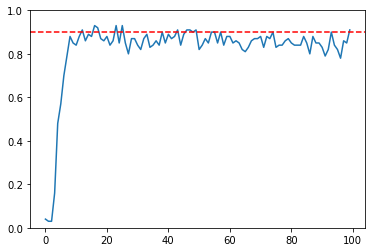

In [59]:
plt.plot(mean_rewards)
plt.ylim(0, 1)
plt.axhline(0.9, color='r', ls='--')

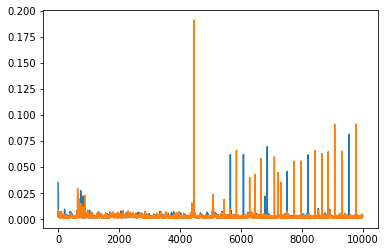

In [60]:
plt.plot([td.total_seconds() for td in pred_times])
plt.plot([td.total_seconds() for td in update_times])

In [61]:
pd.Series(
    [
        td.total_seconds()
        for td in pred_times
    ]
).describe(
    percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
)

count    10000.000000
mean         0.002571
std          0.001943
min          0.001452
1%           0.001543
5%           0.001598
10%          0.001640
25%          0.001744
50%          0.002313
75%          0.002916
90%          0.003677
95%          0.004270
99%          0.006583
max          0.081735
dtype: float64

In [62]:
pd.Series(
    [
        td.total_seconds()
        for td in update_times
    ]
).describe(
    percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
)

count    10000.000000
mean         0.002601
std          0.003189
min          0.001456
1%           0.001532
5%           0.001593
10%          0.001634
25%          0.001738
50%          0.002286
75%          0.002869
90%          0.003628
95%          0.004208
99%          0.006561
max          0.191177
dtype: float64

# Run async simulation

In [177]:
host = 'http://192.168.1.3:228'

In [193]:
r.post(
    host+'/predict',
    json={
        'id': -1,
        'context': make_context('Living Room', 'morning'),
    },
).json()

{'action': 0.002403499558568001, 'pdf_value': 0.0031250000465661287}

In [312]:
rewards = []
pred_times = []
update_times = []
for i in tqdm(range(2_000)):
    context = make_context(
        room=random.choice(["Living Room", "Bedroom"]),
        time_of_day=random.choice(["morning", "afternoon"]),
    )
    prediction_start = datetime.now()
    prediction = r.post(
        host+'/predict',
        json={
            'id': i,
            'context': context,
        },
    ).json()
    pred_times.append(datetime.now() - prediction_start)

    cost = get_cost(context, prediction['action'])

    with dbm.open(str(data_path.joinpath('labels')), 'c') as labels_db:
        labels_db[str(i)] = ujson.dumps(
            make_label(
                    prediction['action'],
                    cost,
                    prediction['pdf_value'],
            ),
        )

    rewards.append(-cost)

    r.post(host+'/save')

  0%|          | 0/2000 [00:00<?, ?it/s]

In [313]:
mean_rewards = [
    sum(rewards[i:i+100])/100
    for i in range(0, len(rewards), 100)
]

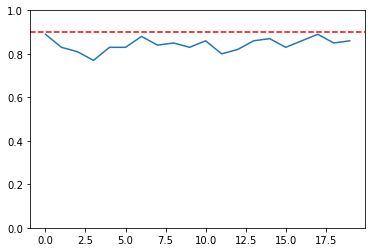

In [314]:
plt.plot(mean_rewards)
plt.ylim(0, 1)
plt.axhline(0.9, color='r', ls='--')

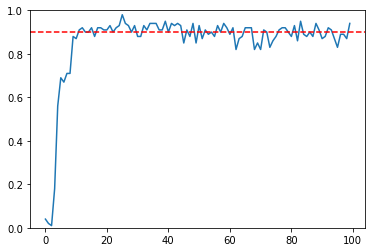

In [135]:
plt.plot(mean_rewards)
plt.ylim(0, 1)
plt.axhline(0.9, color='r', ls='--')

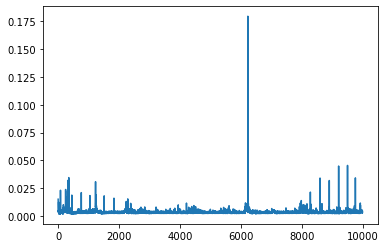

In [147]:
plt.plot([td.total_seconds() for td in pred_times])

In [148]:
pd.Series(
    [
        td.total_seconds()
        for td in pred_times
    ]
).describe(
    percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
)

count    10000.000000
mean         0.003330
std          0.002515
min          0.001773
1%           0.002103
5%           0.002242
10%          0.002306
25%          0.002484
50%          0.003008
75%          0.003613
90%          0.004371
95%          0.005161
99%          0.009076
max          0.179693
dtype: float64